In [142]:
import numpy as np
import pandas as pd
import importlib
import data_utils
importlib.reload(data_utils)
import pipeline
importlib.reload(pipeline)
import pipelines
importlib.reload(pipelines)
import draw_utils
importlib.reload(draw_utils)
import linreg_utils
importlib.reload(linreg_utils)
from pipeline import Pipeline

Ради интереса я решил написать свою мини-библиотеку, с помощью которой можно конфигурировать обработку данных и делать красивые визуализации

## Загрузка и преобразование данных

In [143]:
pipe = Pipeline('generate_data')
pipe.generate('dataset', pd.read_csv, filepath_or_buffer="_file")
pipe.transform('dataset', 'features', lambda df: df.drop('Price(euro)', axis=1))
pipe.transform('dataset', 'labels', lambda df: df['Price(euro)'])
pipe.transform('features', 'features_names', lambda f: f.columns)
pipe.transform('features', 'X', data_utils.to_mat)
pipe.transform('labels', 'Y', data_utils.to_mat)
cars_cat_num = pipe.process_copy("cat_num", _file='data/cars_cat_num.csv')
cars_onehot = pipe.process_copy("onehot", _file='data/cars_onehot.csv')

In [144]:
reg= Pipeline('reg')
reg.subpipeline(pipelines.transform_data())
reg.subpipeline(pipelines.prepare_data())
reg.subpipeline(pipelines.split_test_train())
reg.subpipeline(pipelines.load_train())
reg.subpipeline(pipelines.train_model([pipelines.gradient_descent(), pipelines.regularization()]))
args = {'_batch':3000, '_RMSE': True, '_loss_MSE':True, "_epochs":30}

### Оценка результатов

In [145]:
def vis_models(pipes):
    def draw_res(stats=[]):
        def do_draw_res(ax, p):
            orig = p.val('Y_orig')
            pred = p.val('Y_pred')
            ax.scatter(np.array(orig), np.array(pred), label="scatter")
            ax.plot([orig.min(), orig.max()], [orig.min(), orig.max()], 'r')
            ax.set_xlabel('orig')
            ax.set_ylabel('pred')
            draw_utils.draw_stats(ax, p, stats)
        return do_draw_res

    draw_utils.draw_plots(pipes, draw_res(["RMSE"]))

In [146]:
test_model = Pipeline('test_model')
test_model.transform('Y', 'Y_orig', lambda Y: Y)
test_model.subpipeline(pipelines.predict())
test_model.subpipeline(pipelines.revert_transform([('Y_orig', 'Y'), ('Y_pred', 'Y')]))
test_model.transform(['Y_pred', 'Y_orig'], 'RMSE', linreg_utils.RMSE)


def train_and_test(data, model, **args):
    model = model.apply_copy(model.name, data, **args)
    draws = [draw_utils.draw_metric(["loss"]), draw_utils.draw_compare_stats('W', labels=list(model.val('features_names'))+['bias'])]
    draw_utils.draw_plots([model], draws, max_cols=1, title="linear_regression")

    pipes = [
        Pipeline.compose_apply("train", model, [pipelines.load_train(), test_model], **args),
        Pipeline.compose_apply("test", model, [pipelines.load_test(), test_model], **args)
    ]

    labels=list(model.val('features_names'))+['bias']
    a = np.ravel(np.abs(model.val('W')))
    ind = np.ravel(np.argpartition(a, -3))[-3:]

    print('Самые значимые веса:')
    for i in ind[np.argsort(-a[ind])]:
        print('\t', labels[i], model.val('W')[0, i])

    vis_models(pipes)

## Обучение и тестирование линейной регрессии

### На категориальных данных, преобразованных в числовые

#### Без предварительной обработки

Самые значимые веса:
	 Model -0.5586830901004615
	 bias 0.36462269850718987
	 km_year -0.2577708687277247


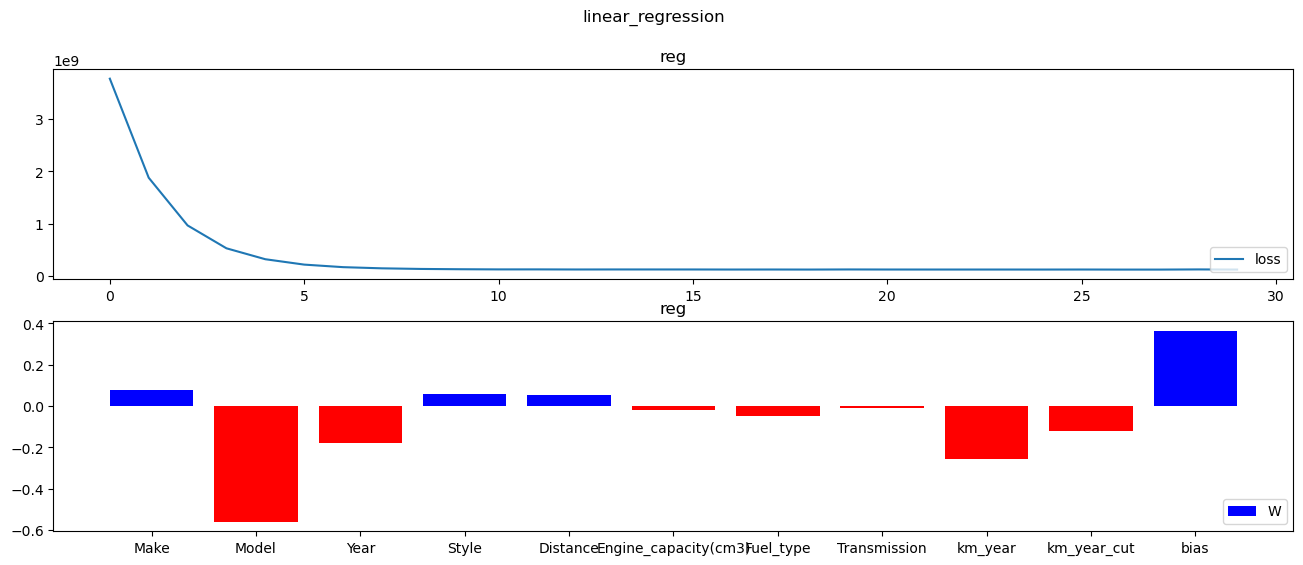

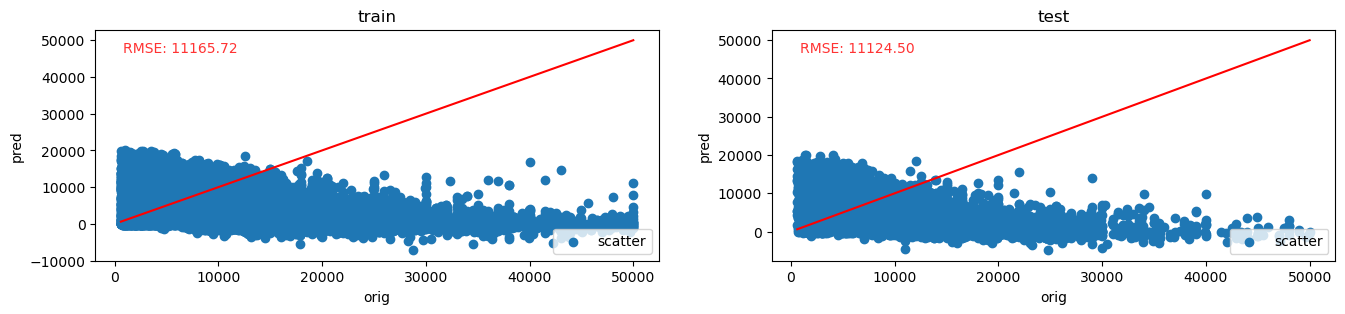

In [147]:
train_and_test(cars_cat_num, reg, **args, _lr=1e-12)

#### На нормализованном наборе данных

Самые значимые веса:
	 Year 0.3824197132174116
	 Engine_capacity(cm3) 0.2720903150510265
	 bias -0.13656236829512744


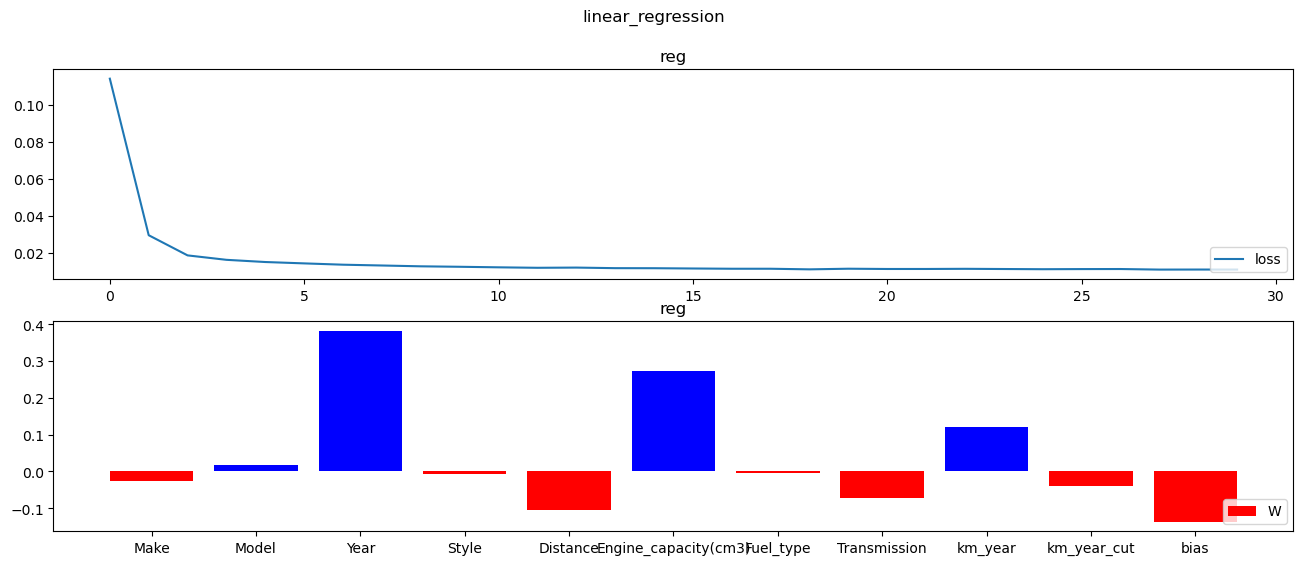

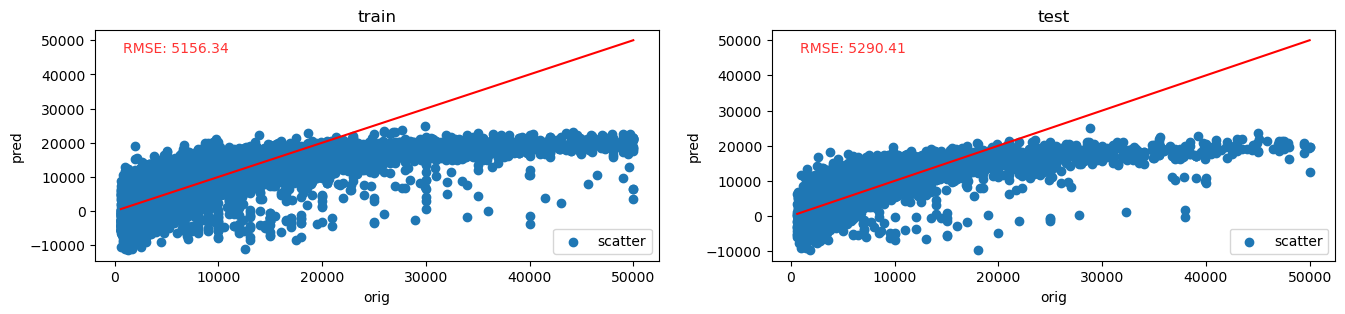

In [148]:
train_and_test(cars_cat_num, reg, **args, _minmax=True, _lr=0.5)

#### На стандартизированном наборе данных

Самые значимые веса:
	 Year 0.3580220941209667
	 Distance -0.2805190603625444
	 Engine_capacity(cm3) 0.26981988967315446


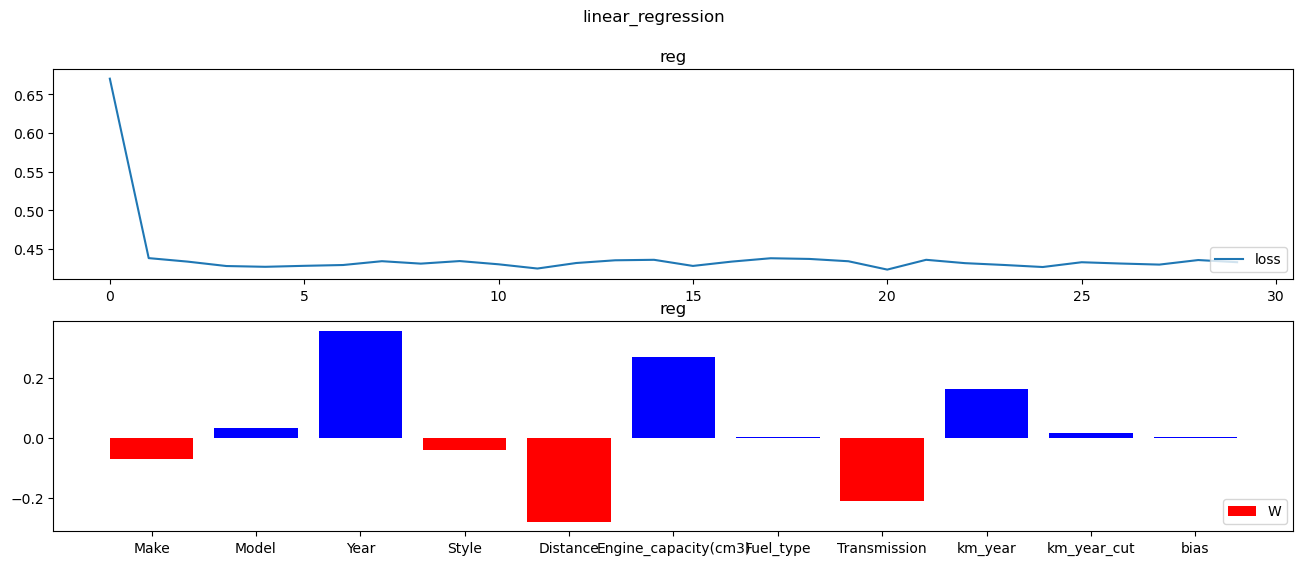

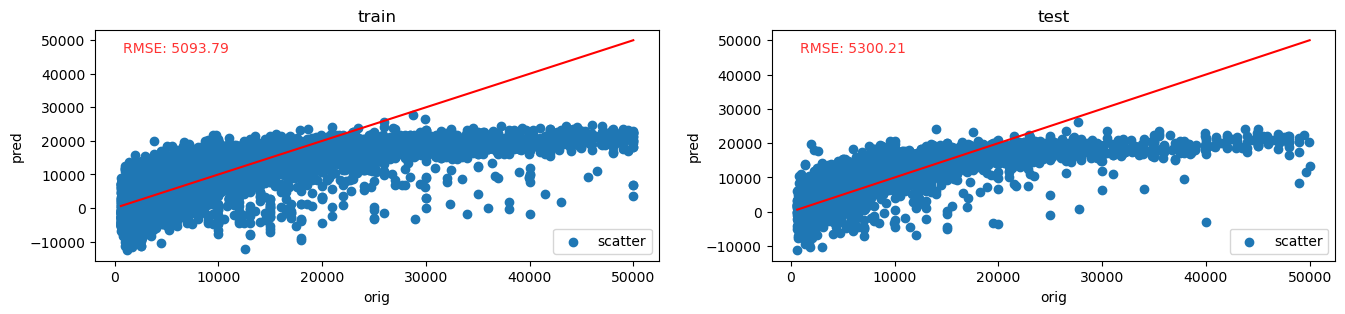

In [149]:
train_and_test(cars_cat_num, reg, **args, _std=True, _lr=0.5)

### На one-hot encoding

#### Без предварительной обработки

Самые значимые веса:
	 Model_Caddy 0.2051833903496336
	 Style_Microvan -0.19754045175517262
	 Model_Combo -0.18444992426234266


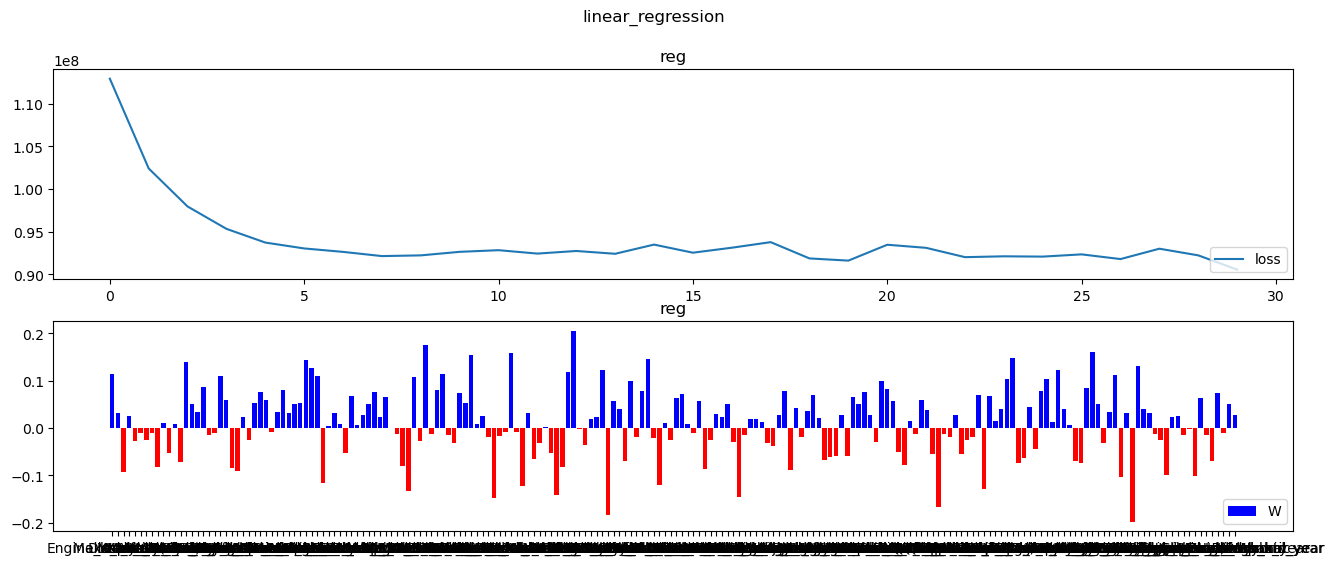

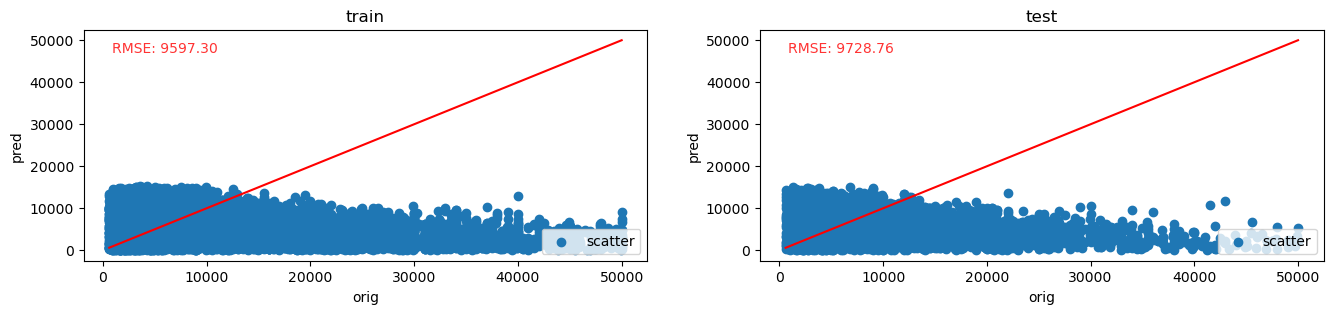

In [150]:
train_and_test(cars_onehot, reg, **args, _lr=1e-12)

#### На нормализованном наборе данных

Самые значимые веса:
	 Distance -0.24979580166295087
	 Year 0.2380424260709398
	 Make_Daewoo -0.17464298796237543


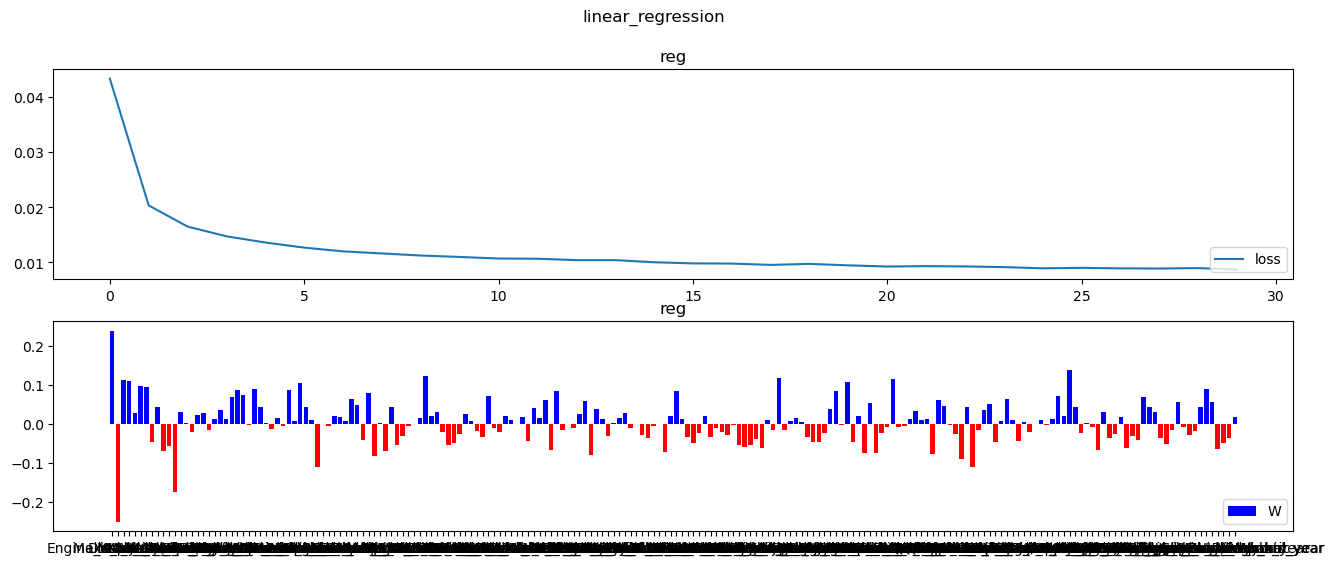

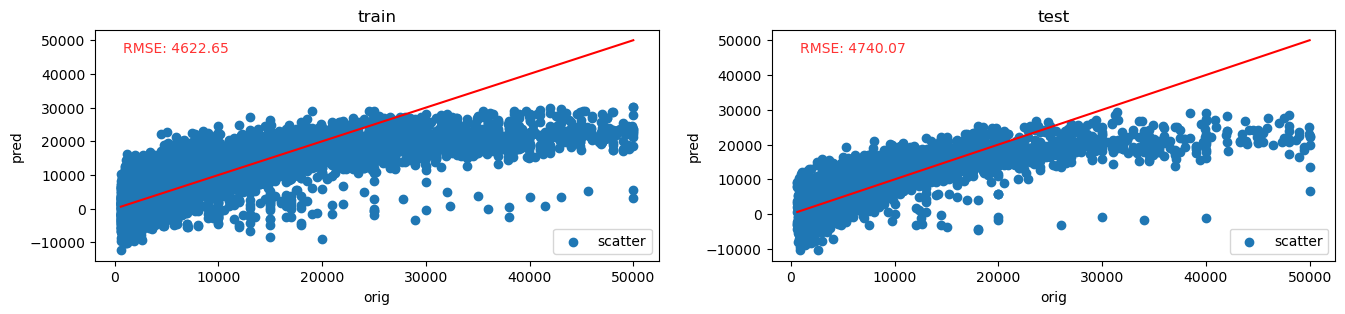

In [151]:
train_and_test(cars_onehot, reg, **args, _minmax=True, _lr=0.5)

#### На стандартизированном наборе данных

Самого лучшего результата добилась модель с использованием onehot encoded набора данных и стандартизации

Самые значимые веса:
	 Year 0.41786078371310353
	 Make_Mercedes 0.2256809089084538
	 Distance -0.22483807368264452


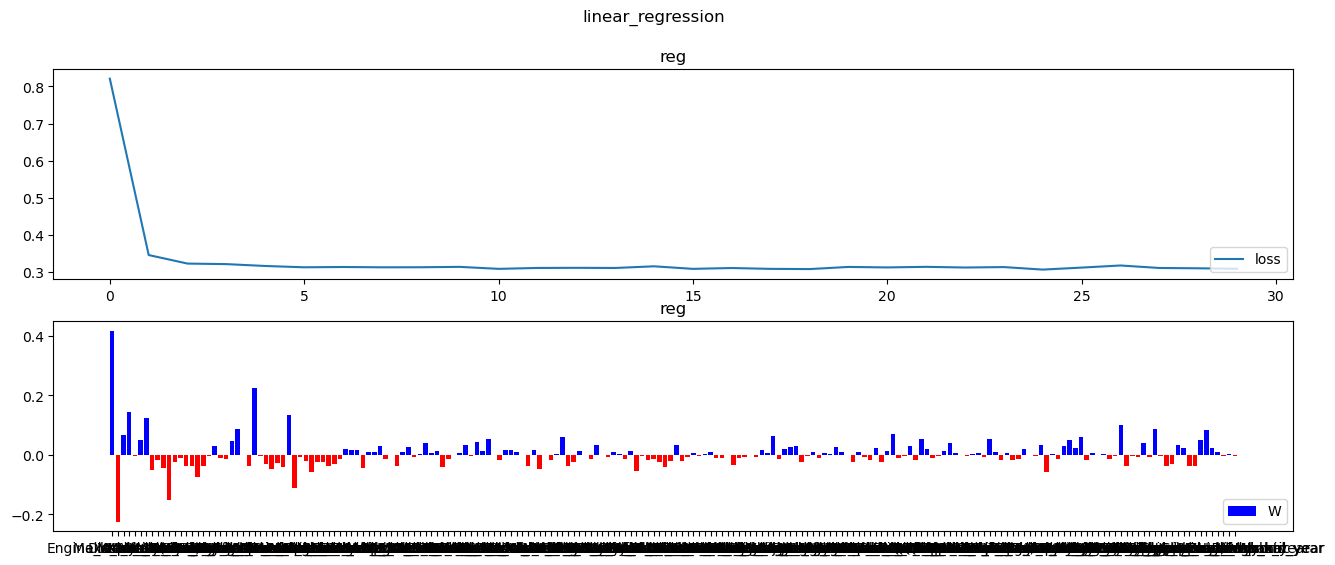

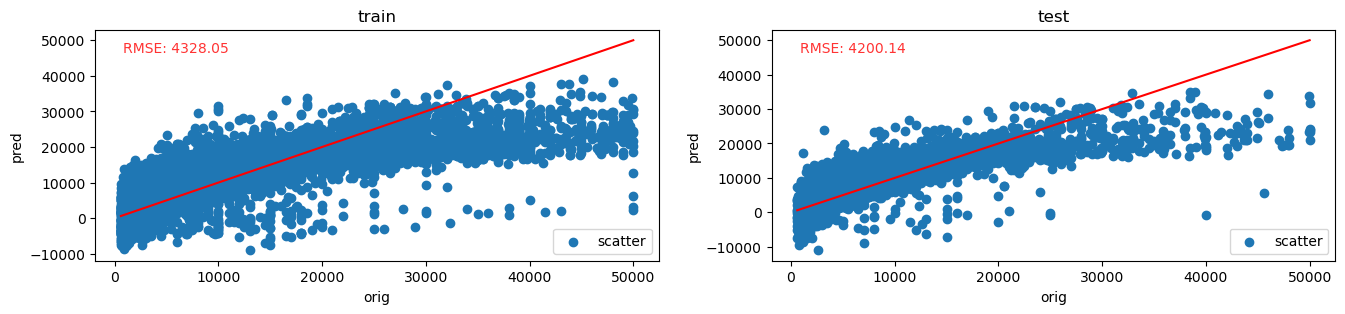

In [152]:
train_and_test(cars_onehot, reg, **args, _std=True, _lr=0.2)